In [ ]:
function birdImageClassifierGUI()
    % Display GPU and CPU information
    if ispc
        [status, cmdout] = system('wmic cpu get name, NumberOfCores, NumberOfLogicalProcessors /format:list');
        disp(cmdout);
    end

    % Prepare the classifier and data
    [svmModel, classNames] = prepareClassifier();

    % Create the UI figure
    fig = uifigure('Name', 'Bird Image Classifier', 'Position', [100, 100, 800, 600]);

    % Create a load button
    btnLoad = uibutton(fig, 'push', 'Text', 'Load Image', ...
                       'Position', [340, 550, 100, 22], ...
                       'ButtonPushedFcn', @(btn,event) loadImageFcn());

    % Create axes for image display
    ax = uiaxes('Parent', fig, 'Position', [50, 100, 700, 400]);
    title(ax, 'No Image Loaded');

    % Label for displaying classification results
    lblResult = uilabel(fig, 'Position', [340, 50, 200, 50], ...
                        'Text', 'Result: None', ...
                        'FontSize', 14);

    % Function to load image and process
    function loadImageFcn()
        [file, path] = uigetfile({'*.jpg;*.tif;*.png;*.gif', 'All Image Files'; '*.*', 'All Files'}, ...
                                 'Select an Image of a Bird', ...
                                 'MultiSelect', 'off');
        if isequal(file, 0)
            disp('User canceled the file selection.');
        else
            fullFileName = fullfile(path, file);
            img = imread(fullFileName);
            imgResized = imresize(img, [224, 224]);
            imshow(imgResized, 'Parent', ax);
            title(ax, 'Image Uploaded');  % Update the title to indicate the image is uploaded

            imgGray = rgb2gray(imgResized);
            imgGray3D = reshape(imgGray, [224, 224, 1]);

            % Extract HOG features from the uploaded image
            imageFeatures = extractHOGFeatures(imgGray3D, 'CellSize', [8 8]);

            % Predict the label of the uploaded image
            imageLabelIndex = predict(svmModel, imageFeatures);
            imageLabel = classNames(imageLabelIndex);

            % Display the predicted label
            lblResult.Text = ['Result: ', char(imageLabel)];
        end
    end

    % Prepare classifier and return trained model and information
    function [svmModel, classNames] = prepareClassifier()
        % Directory containing image folders for each bird species
        dataDir = 'C:\American_Birds'; % Adjust the path as needed

        % Create image datastore
        imds = imageDatastore(dataDir, 'IncludeSubfolders', true, 'LabelSource', 'foldernames');
        classNames = unique(imds.Labels, 'stable');

        % Split data into training and test sets
        [imdsTrain, ~] = splitEachLabel(imds, 0.8, 'randomized');

        % Prepare the first image to determine feature length
        sampleImage = readimage(imdsTrain, 1);
        sampleImageResized = imresize(sampleImage, [224 224]);
        sampleImageGray = rgb2gray(sampleImageResized);
        sampleImageGray3D = reshape(sampleImageGray, [224, 224, 1]);

        % Extract HOG features to find feature size
        cellSize = [8 8];
        hogFeatureSize = length(extractHOGFeatures(sampleImageGray3D, 'CellSize', cellSize));

        % Initialize feature and label arrays
        trainFeatures = zeros(length(imdsTrain.Files), hogFeatureSize, 'single');
        trainLabels = imdsTrain.Labels;

        % Process each training image
        for i = 1:length(imdsTrain.Files)
            img = readimage(imdsTrain, i);
            imgResized = imresize(img, [224 224]);
            imgGray = rgb2gray(imgResized);
            imgGray3D = reshape(imgGray, [224, 224, 1]);
            trainFeatures(i, :) = extractHOGFeatures(imgGray3D, 'CellSize', cellSize);
        end

        % Train SVM classifier
        svmModel = fitcecoc(trainFeatures, trainLabels, 'Learners', 'Linear', 'Coding', 'onevsall');
    end
end


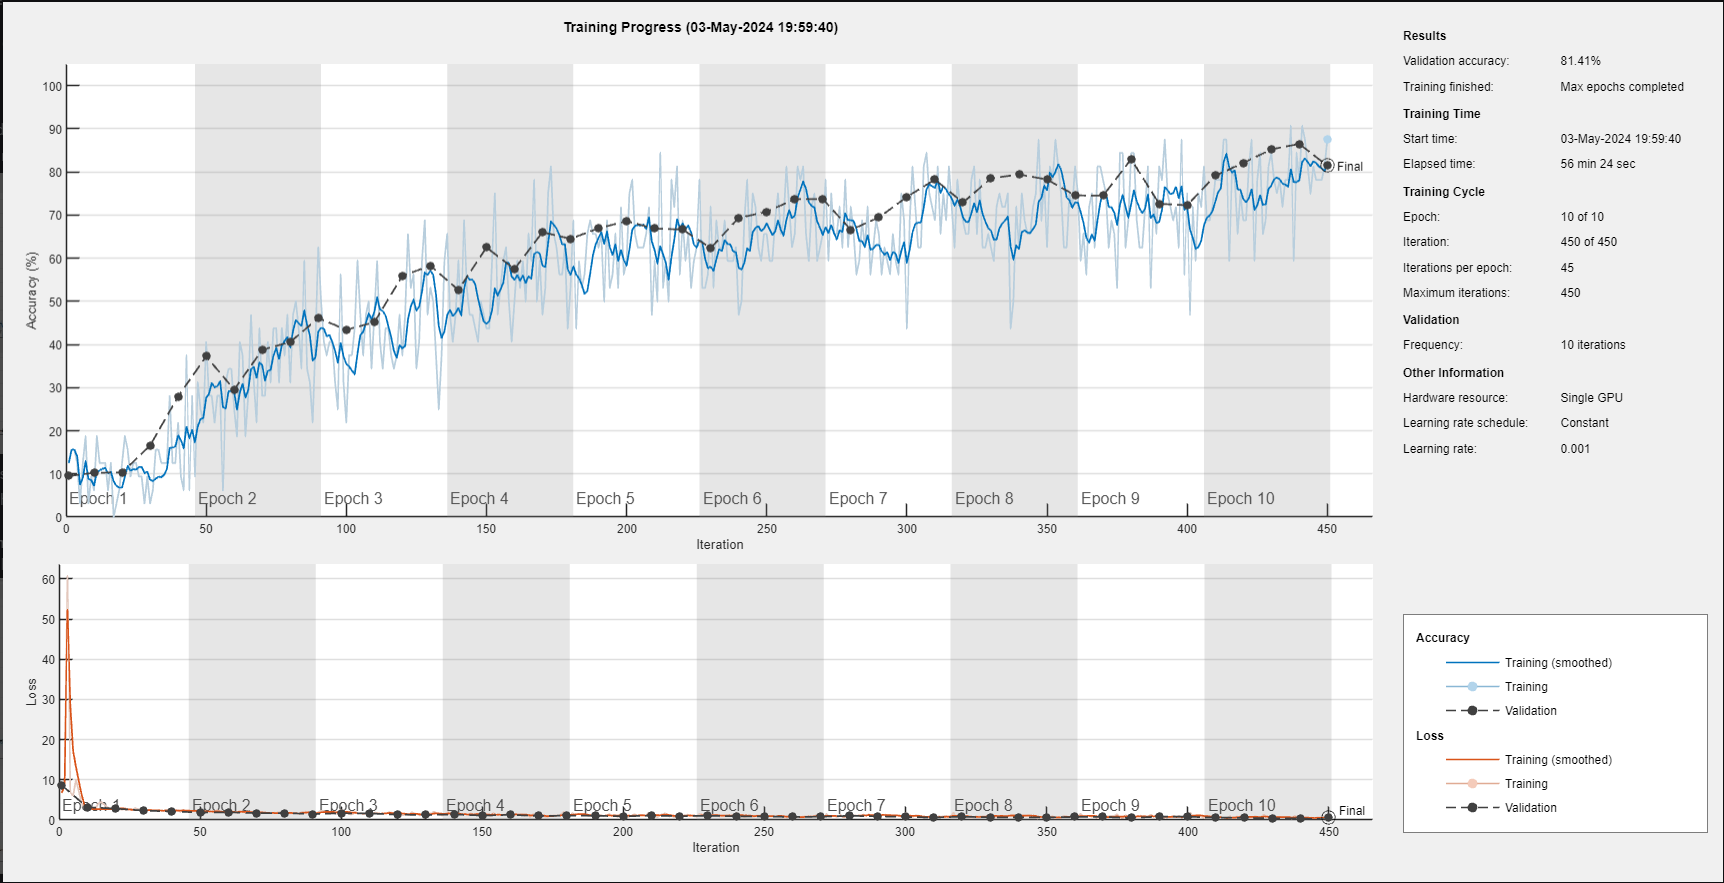


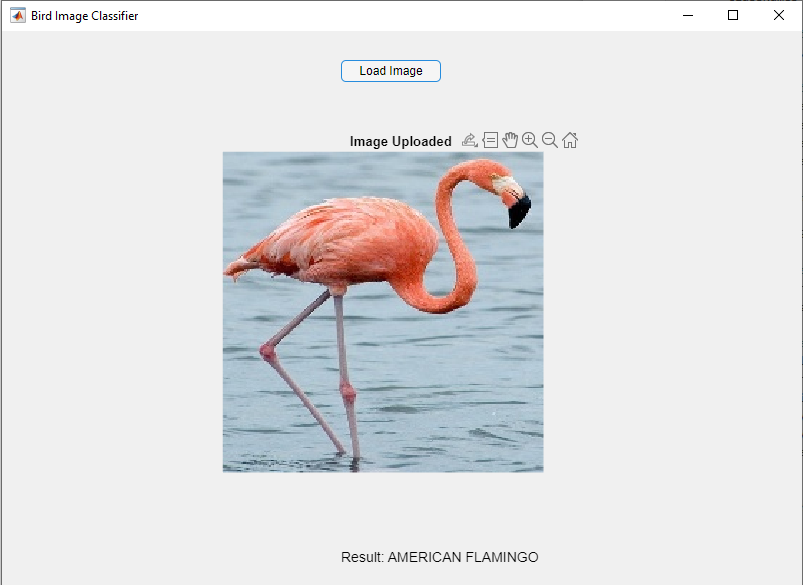